In [82]:
%pylab inline
%config InlineBackend.close_figures=False

Populating the interactive namespace from numpy and matplotlib


In [83]:
from Quaternion import Quat
from astropy.table import Table
import calc_si_align

The calc_si_align.calc_si_align method takes as input Y and Z offsets and a misalignment matrix and returns a new single alignment matrix that contains the combined operations to apply that misalignment matrix *with* those Y and Z offsets.  In practice the calc_si_align method will be used to add Y and Z offsets that describe the offset of the "current" aimpoint from the POG/planning aimpoint, but here we verify the signs applied by calc_si_align, by using it to "absorb" large target offsets.  We then confirm that the two methods (misalignment matrix with offsets vs combined/absorbed alignment matrix) give us the same relative placement of target OFLS PCAD quaternion.  

These ArLac CAL observations have large (10 arcmin) target offsets in a square/diamond pattern.


In [84]:
arlac_text = """obsid  targ_ra        targ_dec     y_det_offset z_det_offset q1            q2          q3           q4         
-----  -------------- ------------ ------------ ------------ ------------  ----------  -----------  ---------- 
17351      332.170000    45.742306     0.000000     0.000000  -0.87203164  0.07848384  -0.43054965  0.21915315 
17368      332.170000    45.742306   -10.000000   -10.000000  -0.87141215  0.07722292  -0.42935394  0.22434949 
17369      332.170000    45.742306    10.000000   -10.000000  -0.87209989  0.07558944  -0.42984057  0.22128058 
17370      332.170000    45.742306    10.000000    10.000000  -0.87080310  0.07615053  -0.43239063  0.22122703 
17371      332.170000    45.742306   -10.000000    10.000000  -0.87003097  0.07762806  -0.43192998  0.22462522 

"""

In [85]:
arlac = Table.read(arlac_text, format='ascii.fixed_width_two_line')

In [86]:
def plot_current_target(t, legloc='lower right'):
    q_pcad = Quat([t['q1'], t['q2'], t['q3'], t['q4']])
    # Calculate the ~hrma quaternion from the pcad quaternion
    q_hrma = q_pcad * Quat(calc_si_align.ODB_SI_ALIGN).inv()
    fig = figure()
    ax = subplot()
    ax.invert_xaxis()
    ax.set_aspect('equal')
    # Calculate the hrma y/z position for a frame centered on the pcad attitude
    y_hrma, z_hrma = calc_si_align.radec2yz(q_hrma.ra, q_hrma.dec, q_pcad)
    y_hrma_arcsec = y_hrma * 3600
    z_hrma_arcsec = z_hrma * 3600
    y_off_arcsec = t['y_det_offset'] * 60
    z_off_arcsec = t['z_det_offset'] * 60
    plot([0], [0], "b+")
    # Plot the position of the hrma aimpoint relative to the pcad attitude
    plot([0, y_hrma_arcsec], [0, z_hrma_arcsec], color='r', label='si_align')
    plot([y_hrma_arcsec],
         [z_hrma_arcsec], 'gx')
    # plot the position of the target via hrma aimpoint and target offset
    plot([y_hrma_arcsec, y_hrma_arcsec + y_off_arcsec], [z_hrma_arcsec, z_hrma_arcsec + z_off_arcsec],
         color='b', label='target_offset')
    # Back check that position by plotting the target coordinate directly
    # (instead of via the aimpoint and offset)
    y_targ, z_targ = calc_si_align.radec2yz(t['targ_ra'], t['targ_dec'], q_pcad)
    y_targ_arcsec = y_targ * 3600
    z_targ_arcsec = z_targ * 3600
    plot([y_targ_arcsec], [z_targ_arcsec], "r+")
    print "Initial target position: {} , {}".format(y_targ_arcsec, z_targ_arcsec)
    xlabel('YANG')
    ylabel('ZANG')
    legend(loc=legloc)
    return fig
    

In [87]:
def plot_absorbed_offset(fig, t, legloc='lower right'):
    # Define a new SI align that "absorbs" the large target offset
    si_align = calc_si_align.calc_si_align(dy_align=t['y_det_offset'] / 60,
                                             dz_align=t['z_det_offset'] / 60,
                                          check_consistency=True)
    q_pcad = Quat([t['q1'], t['q2'], t['q3'], t['q4']])
    # Calculate the ~hrma quaternion from the pcad quaternion
    q_hrma = q_pcad * Quat(si_align).inv()
    
    # Calculate the hrma y/z position for a frame centered on the pcad attitude
    y_hrma, z_hrma = calc_si_align.radec2yz(q_hrma.ra, q_hrma.dec, q_pcad)
    y_hrma_arcsec = y_hrma * 3600
    z_hrma_arcsec = z_hrma * 3600
    print "New hrma position: {} , {}".format(y_hrma_arcsec, z_hrma_arcsec)

    # Plot the position of the hrma aimpoint relative to the pcad attitude
    figure(fig.number)
    plot([0, y_hrma_arcsec], [0, z_hrma_arcsec], color='g', label='new_si_align')

    legend(loc=legloc)
    return fig
    
    

For each of the "large offset" arlac pointings, we calculate the "flight" position in yang and zang of the hrma aimpoint and the position of the target using target offsets.

Then, we "absorb" the large target offsets into a new si_align, and redetermine the position of the hrma aimpoint.  This new hrma aimpoint position coincides with the original target position, verifying the signs of the calc_si_align method.  The numbers work out, and on the plots there aren't any lines heading off away from the three plotted points.

Initial target position: -530.40341878 , -543.602861928
New hrma position: -530.405234228 , -543.602737942
Initial target position: 669.596333662 , -543.602248563
New hrma position: 669.600470155 , -543.597157393
Initial target position: 669.597373321 , 656.407427177
New hrma position: 669.601087298 , 656.402349536
Initial target position: -530.404233833 , 656.402813008
New hrma position: -530.405245768 , 656.399996063


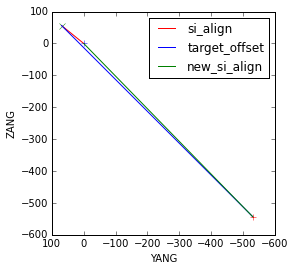

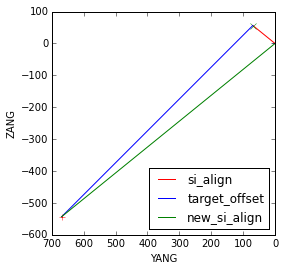

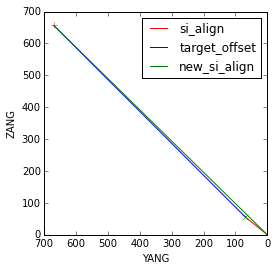

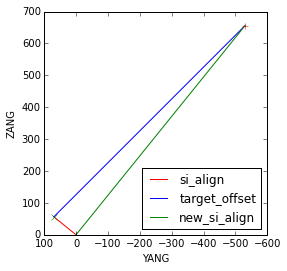

In [88]:
leglocs = ['upper right',
           'lower right',
           'upper right',
           'lower right']
for target, legloc in zip(arlac[1:], leglocs):
    fig = plot_current_target(target)
    updated_fig = plot_absorbed_offset(fig, target, legloc)